# Convolutional Neural Network

**Import all the packages down bellow, we'll need that sooner or later**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt  
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline  

*Checking the number of GPUs, don't worry if you are doing that using a CPU*

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs available:  0


IndexError: list index out of range

# Data preparation

*The images included in the data/cats-and-dogs directory are a random subset of the full cat and dog dataset from the  following Kaggle competition: https://www.kaggle.com/c/dogs-vs-cats/data*

**One thousand imgs for training, 200 for validating, 100 for testing**

In [3]:
# Organizing data into train, valid, test dirs
os.chdir(r'C:\Machine_Learning\dogs-vs-cats\train')

if os.path.isdir('train/dog') is False: #Set False to ensure this dir doesn't already exist
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')

    for c in random.sample(glob.glob('cat*'), 500):
        shutil.move(c, 'train/cat')
    for c in random.sample(glob.glob('dog*'), 500):
        shutil.move(c, 'train/dog')
    for c in random.sample(glob.glob('cat*'), 100):
        shutil.move(c, 'valid/cat')
    for c in random.sample(glob.glob('dog*'), 100):
        shutil.move(c, 'valid/dog')
    for c in random.sample(glob.glob('cat*'), 50):
        shutil.move(c, 'test/cat')
    for c in random.sample(glob.glob('dog*'), 50):
        shutil.move(c, 'test/dog')

os.chdir('..')  

**We are just gong to create these variables down bellow**

*Specifying dirs*


In [4]:
train_path = r'C:\Machine_Learning\dogs-vs-cats\train\train'
valid_path = r'C:\Machine_Learning\dogs-vs-cats\train\valid'
test_path = r'C:\Machine_Learning\dogs-vs-cats\train\test'

**The following cell will show how much dat you might find at each of the dirs we just created**

*Whenever we train our model we'll use a data type our model expects*

*We are going to train a Keras Sequential Model the model will receive data whenever we call the fit.function*

*We're going to put our images and do the format of a Keras generator*

*Basically, it's going to create batches of data from train, valid and test that our model can understand*

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224, 224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224, 224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224, 224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


*Preprocessing_function will make some type of process on images before passing them to a Neural Network*

**We're going to verify what had been set**

In [6]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes== valid_batches.num_classes == 2

**We are going to grab a single batch and corresponding labels from train batches**

In [7]:
imgs, labels = next(train_batches)

**This function will plot images in the form of a grid with 1 row and 10  columns where images are placed**

In [8]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

**Plot imgs and printing corresponding labels**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

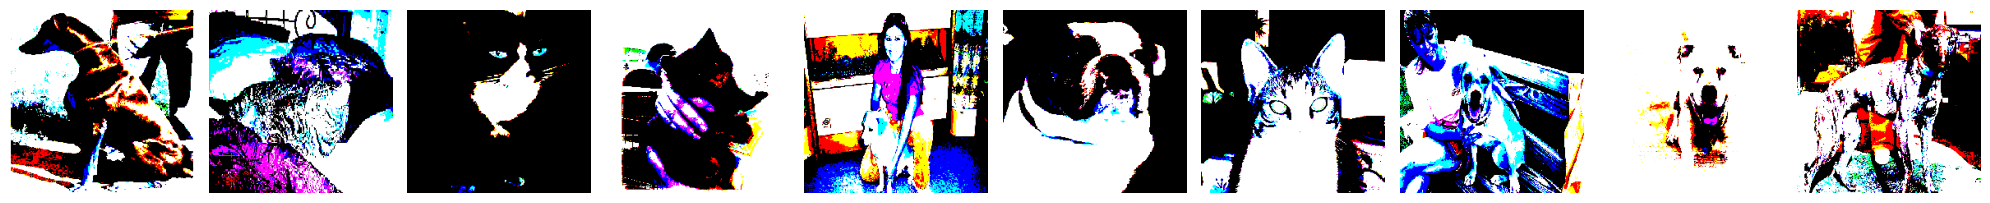

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [9]:
plotImages(imgs)
print(labels)

*Obtained, organized on disk and processed it*

 # Build and train a CNN

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt  
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline  

In [11]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),   
    Flatten(),
    Dense(units=2, activation='softmax'),
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [13]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',  metrics=['accuracy'])

In [14]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
100/100 - 101s - loss: 18.2442 - accuracy: 0.5380 - val_loss: 8.6774 - val_accuracy: 0.5750 - 101s/epoch - 1s/step
Epoch 2/10
100/100 - 118s - loss: 2.6705 - accuracy: 0.7460 - val_loss: 3.9428 - val_accuracy: 0.6250 - 118s/epoch - 1s/step
Epoch 3/10
100/100 - 123s - loss: 0.7826 - accuracy: 0.8720 - val_loss: 2.6566 - val_accuracy: 0.6550 - 123s/epoch - 1s/step
Epoch 4/10
100/100 - 125s - loss: 0.3742 - accuracy: 0.9160 - val_loss: 2.4351 - val_accuracy: 0.6350 - 125s/epoch - 1s/step
Epoch 5/10
100/100 - 127s - loss: 0.0148 - accuracy: 0.9960 - val_loss: 2.5573 - val_accuracy: 0.6200 - 127s/epoch - 1s/step
Epoch 6/10
100/100 - 129s - loss: 0.0057 - accuracy: 0.9980 - val_loss: 2.4108 - val_accuracy: 0.6550 - 129s/epoch - 1s/step
Epoch 7/10
100/100 - 127s - loss: 9.4196e-04 - accuracy: 1.0000 - val_loss: 2.4227 - val_accuracy: 0.6550 - 127s/epoch - 1s/step
Epoch 8/10
100/100 - 130s - loss: 4.9066e-04 - accuracy: 1.0000 - val_loss: 2.4214 - val_accuracy: 0.6500 - 130s/epoch -

# Predict

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

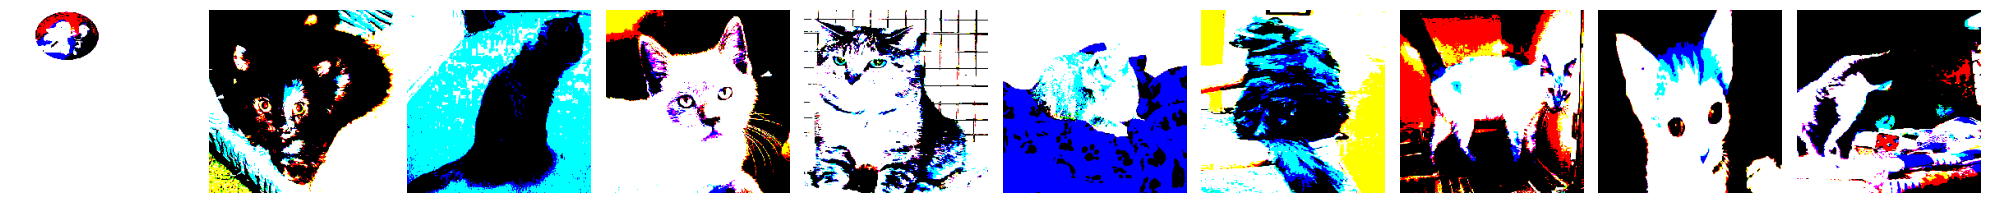

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [15]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [16]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [17]:
predictions = model.predict(x=test_batches, verbose=0)

In [18]:
np.round(predictions)

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.

In [19]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [20]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    """
       This function plots and prints the confusion matrix.
       Normalization can be applied by setting 'normalize=True'
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[28 22]
 [15 35]]


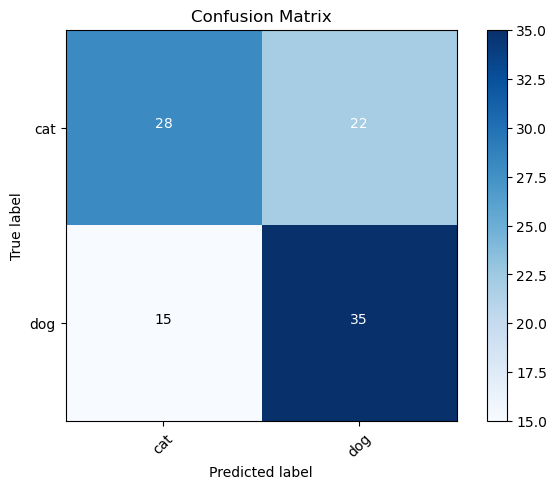

In [22]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Build Fine-tuned VGG16 model

*The model has to be downloaded (Since 2014 :) it still works fine*

In [23]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [24]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [25]:
def count_params(model):
    non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_weights])
    trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
    return {'non_trainable_params': non_trainable_params, 'trainable_params': trainable_params}

In [26]:
vgg16_model = tf.keras.applications.vgg16.VGG16()
params = count_params(vgg16_model)

In [27]:
params = count_params(vgg16_model)
assert params['non_trainable_params'] == 0
assert params['trainable_params'] == 138357544

In [28]:
type(vgg16_model)

keras.engine.functional.Functional

In [29]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [31]:
params = count_params(model)
assert params['non_trainable_params'] == 0
assert params['trainable_params'] == 134260544

**The cell bellow frezees the trainable parameters, or the weights and biases from all layer so it dooesn't have to be retrained**

In [32]:
for layer in model.layers:
    layer.trainable = False

**Now we are going to add our output layer which had thousand classes in order to have 2: Cats and Dogs**

In [33]:
model.add(Dense(units=2, activation='softmax'))

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [35]:
count = count_params(model)
assert count['non_trainable_params'] == 134260544
assert count['trainable_params'] == 8194

# Train the fine-tuned VGG16 model

In [36]:
 model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',  metrics=['accuracy'])

**Passing our data set stored in train_batches and validation set stored as valid_batches...**

In [37]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)

Epoch 1/5
100/100 - 1518s - loss: 0.2049 - accuracy: 0.9100 - val_loss: 0.0799 - val_accuracy: 0.9800 - 1518s/epoch - 15s/step
Epoch 2/5
100/100 - 1481s - loss: 0.0691 - accuracy: 0.9760 - val_loss: 0.0580 - val_accuracy: 0.9750 - 1481s/epoch - 15s/step
Epoch 3/5
100/100 - 1412s - loss: 0.0414 - accuracy: 0.9850 - val_loss: 0.0503 - val_accuracy: 0.9800 - 1412s/epoch - 14s/step
Epoch 4/5
100/100 - 1386s - loss: 0.0311 - accuracy: 0.9900 - val_loss: 0.0444 - val_accuracy: 0.9800 - 1386s/epoch - 14s/step
Epoch 5/5
100/100 - 1423s - loss: 0.0219 - accuracy: 0.9950 - val_loss: 0.0420 - val_accuracy: 0.9750 - 1423s/epoch - 14s/step


**After fine-tuning our model we can notice how fine it is generalizing**

# Predict using fine-tuned VGG16 model

**Using our model to get predictions from our 'test set' which is stored in 'test_batches'**

In [38]:
predictions = model.predict(x=test_batches, verbose=0)

In [39]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [40]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=1))

In [41]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

*Here we can see how well is the fine-tuned VGG16 model when generalzing data we had not seen while training*

Confusion matrix, without normalization
[[49  1]
 [ 1 49]]


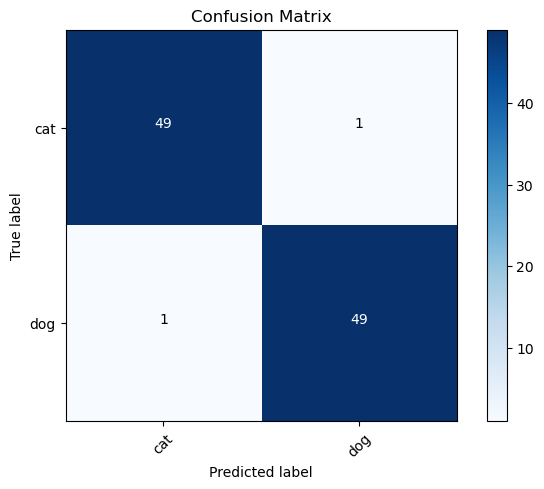

In [43]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

**Fine tuned VGG16 model does really well at generalizing**